# LSTM RNN 文本分类

TensorFlow 2.X 实现 LSTM RNN 模型，使用 IMDB 电影评论数据集，完成情感分析任务。对于电影评论，要么是正面的，要么是负面的，所以该情感分析任务实际上就是文本分类任务。

来源：[https://www.tensorflow.org/tutorials/text/text_classification_rnn](https://www.tensorflow.org/tutorials/text/text_classification_rnn)



In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

tf.__version__

'2.2.0-rc3'

## 数据

使用 IMDB 电影评论数据集。

In [2]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteILMNN2/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteILMNN2/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteILMNN2/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
encoder = info.features['text'].encoder

In [4]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [6]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = (train_examples.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

test_dataset = (test_examples.padded_batch(BATCH_SIZE, padded_shapes=([None],[])))

## 模型

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 训练

In [11]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 127s 326ms/step - loss: 0.6408 - accuracy: 0.5745 - val_loss: 0.5113 - val_accuracy: 0.7797
Epoch 2/10
391/391 [==============================] - 126s 323ms/step - loss: 0.3636 - accuracy: 0.8504 - val_loss: 0.3478 - val_accuracy: 0.8573
Epoch 3/10
391/391 [==============================] - 125s 319ms/step - loss: 0.2626 - accuracy: 0.8981 - val_loss: 0.3331 - val_accuracy: 0.8661
Epoch 4/10
391/391 [==============================] - 126s 321ms/step - loss: 0.2161 - accuracy: 0.9199 - val_loss: 0.3320 - val_accuracy: 0.8677
Epoch 5/10
391/391 [==============================] - 126s 323ms/step - loss: 0.1852 - accuracy: 0.9317 - val_loss: 0.3686 - val_accuracy: 0.8672
Epoch 6/10
391/391 [==============================] - 126s 322ms/step - loss: 0.1741 - accuracy: 0.9374 - val_loss: 0.3633 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 126s 322ms/step - loss: 0.1556 - accuracy: 0.9444 - val_loss: 0.3735 -

## 评估

In [12]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 50s 128ms/step - loss: 0.4127 - accuracy: 0.8542
Test Loss: 0.41273197531700134
Test Accuracy: 0.8541600108146667


In [ ]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [15]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-1.7330607]]


In [16]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-2.8512654]]


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

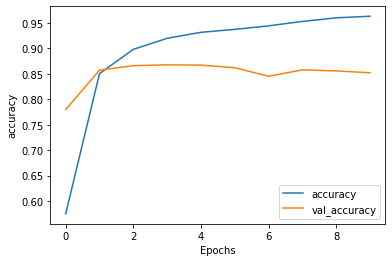

In [18]:
plot_graphs(history, 'accuracy')

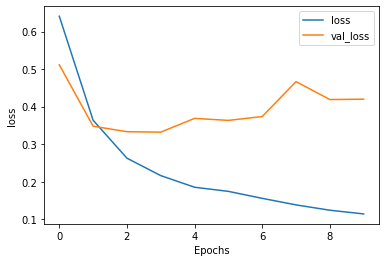

In [19]:
plot_graphs(history, 'loss')